In [1]:
import torch
import torch.nn as nn
from models.meshfreeSR import UNet3D,meshfreeSR
from models.ndInterp import NDLinearInterpolation
import numpy as np
import time

def GaussianRing(grid,radius,sigma):
	r = np.sqrt(grid[0]**2+grid[1]**2+grid[2]**2)
	return 1./(sigma*np.sqrt(2*3.1415))*np.exp(-1/2*((r-radius)/sigma)**2)

def Gaussian3D(grid,sigma):	
	dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(3).to(device),(torch.eye(3)*sigma).to(device))
	return dist.log_prob(grid.to(device)).to(device)

def genSlice(grid,time,n_grid=32):
	return Gaussian3D(grid.view(3,-1).T,time).view(n_grid,n_grid,n_grid).unsqueeze(0)
	

In [2]:
device = 'cpu'

n_dim = 4
n_slice = 5
n_grid = 32
n_layers = 3
linear_size = 256

In [3]:
space_axis = torch.linspace(-5,5,n_grid).to(device)
time_axis = torch.linspace(0.5,2.5,n_slice).to(device)
grid = torch.stack(torch.meshgrid(space_axis,space_axis,space_axis)).to(device)

train_grid = torch.stack(torch.meshgrid(time_axis,space_axis,space_axis,space_axis)).to(device)
train_context = torch.stack([torch.tensor(GaussianRing(grid.cpu(),i,i/2)).unsqueeze(0) for i in time_axis]).to(device)
train_loc = torch.cat((torch.ones((n_grid**3,1)).to(device)*0.75,grid.reshape(3,-1).T),axis=1)
train_loc = torch.cat((train_loc,torch.cat((torch.ones((n_grid**3,1)).to(device)*1.25,grid.reshape(3,-1).T),axis=1).to(device)),axis=0)
train_loc = torch.cat((train_loc,torch.cat((torch.ones((n_grid**3,1)).to(device)*1.75,grid.reshape(3,-1).T),axis=1).to(device)),axis=0)
train_loc = train_loc*0.99
train_value = GaussianRing(grid.cpu(),0.75,0.75/2).reshape(-1).unsqueeze(-1).to(device)
train_value = torch.cat((train_value,GaussianRing(grid.cpu(),1.25,1.25/2).reshape(-1).unsqueeze(-1).to(device)),axis=0)
train_value = torch.cat((train_value,GaussianRing(grid.cpu(),1.75,1.75/2).reshape(-1).unsqueeze(-1).to(device)),axis=0)

train_value = train_value[:,0]

xmin = torch.tensor([0.5,-5,-5,-5]).float().to(device)
xmax = torch.tensor([2.5,5,5,5]).float().to(device)

<ipython-input-3-2d9109e03556>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_context = torch.stack([torch.tensor(GaussianRing(grid.cpu(),i,i/2)).unsqueeze(0) for i in time_axis]).to(device)


In [4]:
grid.shape

torch.Size([3, 32, 32, 32])

In [5]:
i = 0.5
torch.tensor(GaussianRing(grid.cpu(),i,i/2)).shape

<ipython-input-5-d9c17f9dbdbc>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(GaussianRing(grid.cpu(),i,i/2)).shape


torch.Size([32, 32, 32])

In [83]:
x = []
y = []
z = []
o = []
gaussian = GaussianRing(grid.cpu(),i,i/2).cpu().numpy()
for i in range(32):
    for j in range(32):
        for k in range(32):
            x.append(grid.cpu().numpy()[0, i, j, k])
            y.append(grid.cpu().numpy()[1, i, j, k])
            z.append(grid.cpu().numpy()[2, i, j, k])
            o.append(gaussian[i, j, k])

In [90]:
min(o), max(o)

(0.013558157, 0.08840283)

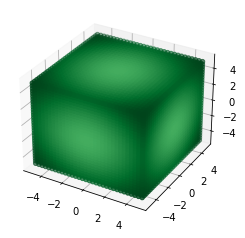

In [84]:
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=o, cmap='Greens');

In [ ]:

mfSR = meshfreeSR(1,16,n_layers,n_dim,linear_size).to(device)
mfSR.train()
optimizer = torch.optim.Adam(mfSR.parameters(), lr=1e-3)
lossFunction = nn.MSELoss()
for i in range(40):
	optimizer.zero_grad()
	output = mfSR(train_context,train_loc,xmin,xmax)
	loss = lossFunction(output.T[0],train_value)
	print(loss)
	loss.backward()
	optimizer.step()


recon_step = 20
recon_ngrid = 64
recon_time = torch.linspace(0.6,2.4,recon_step)
recon_axis = torch.linspace(-4.9,4.9,recon_ngrid)
recon_point = torch.stack(torch.meshgrid(recon_time,recon_axis,recon_axis,recon_axis)).reshape(4,-1).T.cuda()

torch.cuda.empty_cache()
temp_time = time.time()
for i in range(100):
	with torch.no_grad():
		recon_result = mfSR(train_context,recon_point,xmin,xmax)

print(temp_time-time.time())

true_grid = torch.stack(torch.meshgrid(recon_axis,recon_axis,recon_axis))
true_result = GaussianRing(true_grid,0.6,0.6/2).to(device).reshape(1,-1)
for i in range(1,recon_step):
	true_result = torch.cat((true_result,GaussianRing(true_grid,recon_time[i],recon_time[i]/2).to(device).reshape(1,-1)),axis=0)


db = {'recon_result':recon_result,'recon_point':recon_point,'train_context':train_context,'train_grid':train_grid,'train_value':train_value,'true_result':true_result}


#torch.save(db,'GaussianRing_5context_3training.torchdb')
